In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import gym
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
env = gym.make('Pendulum-v0')
ACTION_SPACE = 11 #这个可以比11大，不一定是11，作用是吧-2,2的动作区间分成这么多份动作，进行操控，这游戏的动作不是离散的

double_dqn和普通dqn的区别在于计算Qtarget的方法不一样。
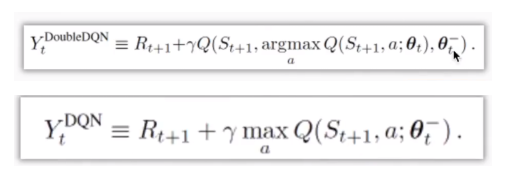

In [3]:
class DoubleDQN:
    def __init__(
        self,
        n_actions,
        n_features,
        learning_rate=0.01,
        reward_decay=0.9,
        e_greedy = 0.9,
        replace_target_iter=300,
        memory_size=500,
        batch_size=32,
        e_greedy_increment=None, #这个是设置epsilon的变化与否的，它是nan证明epsilon一直不变
        output_graph=False,
        
        #实现两种网络的对比，默认是double_DQN
        double_q = True
    ):
        '''动作数量，状态数量'''
        #在属性里面也定义好double_q
        self.double_q = double_q
        
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        #如果e_greedy_increment不是none，那么刚开始动作是瞎选的，随着learn的次数增多
        #epsilon值慢慢增加，每次增加e_greedy_increment直到最大，使得随机选动作的概率变小
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max
        
        # 总共的学习步数，执行一次learn函数，这个值才加一
        self.learn_step_counter = 0
        
        # 初始化[s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features*2 + 2))  #500行,有6列：s占2列，a占1列，r占1列，s_占2列；
        
        # [target_net, evalunet]
        self._build_net()   #因为self.target_net和self.evalunet这两个网络是在这个方法里产生的，别的方法要去调用他们，
        #要么这两个网络在别的方法里先被运行出来，就可以被调用了
        #要么这两个网络一开始就变成全局的变量，不用别的方法每次都运行一遍。！
        
        self.cost_his = []     #这一句是创造一个记录损失的列表
        
    def _build_net(self):
        '''建立预测模型和target模型'''
        #----------------------------------build evaluate model--------------------------------
        # 输入状态，None,2 ;输出动作对应的值 None,4 四个动作每个都对应一个动作价值
        s = tf.keras.layers.Input(shape=(self.n_features,), name='s')
        q_target = tf.keras.layers.Input(shape=(self.n_actions,), name='q_target')
        
        # 预测模型
        x = tf.keras.layers.Dense(20, activation='relu', name='l1')(s)
#         x = tf.keras.layers.Dense(10, activation='relu', name='l1_2')(x)
        x = tf.keras.layers.Dense(self.n_actions, name='l2')(x)
        self.eval_net = tf.keras.Model(inputs=s, outputs=x)
        
        #损失函数
        self.loss = tf.keras.losses.MeanSquaredError()
        
        #优化器
        self._train_op = tf.keras.optimizers.RMSprop(learning_rate=self.lr)
        
        #-----------------------------------build target model------------------------------------
        #目标模型就是一个框架，他不需要训练，只需要把预测模型里面的权重往里更新即可
        s_ = tf.keras.layers.Input(shape=(self.n_features,), name='s_')
        
        #目标模型
        x = tf.keras.layers.Dense(20, activation='relu', name='l1')(s_)
#         x = tf.keras.layers.Dense(10, activation='relu', name='l1_2')(x)
        x = tf.keras.layers.Dense(self.n_actions, name='l2')(x)
        self.target_net = tf.keras.Model(inputs=s_, outputs=x)
        
    def replace_target(self):
        '''预测模型的权重更新到目标模型'''
        #使用set_weights和get_weights的方法对每层的权重进行复制转移
        self.target_net.get_layer(name='l1').set_weights(self.eval_net.get_layer(name='l1').get_weights())
        self.target_net.get_layer(name='l2').set_weights(self.eval_net.get_layer(name='l2').get_weights())
        
    def store_transition(self, s, a, r, s_):  #这里传入的a是一个动作！
        '''存入记忆库'''
        if not hasattr(self, 'memory_counter'):
            #返回对象是否具有具有给定名称的属性。从上面来看，是没有的，那么hasattr会返回FALSE，也就是说如果没有，就会执行下面语句
            self.memory_counter = 0
        
        transition = np.hstack((s, [a,r], s_))
        
        # 替换旧的memory，当memory计数500次，下一次就会更新memory的第一行，。。。
        index = self.memory_counter % self.memory_size  #取余
        self.memory[index, :] = transition
        
        self.memory_counter += 1
    
    def choose_action(self, observation):
        '''选择动作的方法'''
        observation = observation[np.newaxis, :]  
        #在s前面增加一个维度，如s原来是[2,]现在变成[1,2]，因为要这样才能符合模型的要求，因为模型要求[None,2]和RNN北京天气讲的单个预测方法一样
        
        # 小于epsilon时候按照动作价值选,用模型预测出四个动作价值，转成numpy之后用最大索引
        if np.random.uniform() < self.epsilon:
            actions_value = self.eval_net(observation).numpy()
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        
        return action
    
    def learn(self):
        '''从记忆库学习'''
        print('learn step is:',self.learn_step_counter)
        if self.learn_step_counter % self.replace_target_iter == 0: 
            #每replace_target次学习更换一次参数,也就是把target模型的参数更新成和evaluate模型参数
            self.replace_target()
            print('\n目标模型的参数已经被替换。')
            
        # 从memory里面采样
        if self.memory_counter > self.memory_size:
            #如果memory存储次数大于了memory表的长度（500）
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)  #从500里面选择32个整数作为索引
        else:
            #会不会出现memorycounter<32的情况，首先让memory记录多少，这是在主循环里面设定的
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size) #从memorycounter范围选取32个整数作为索引
        
        batch_memory = self.memory[sample_index, :]  #从memory表里面取出上面32个索引对应的行作为batchmemory
        
        with tf.GradientTape() as tape:
            # batch_memory一共32行，6列，前2列s,action1列，r1列，最后两列s_.所以是把s_放到target网络里面，得到q_next[32,4],一个q表
            
            #生成之前的结果，是以前的模型生成的，是一个[32,4]的tensor
            q_next = self.target_net(batch_memory[:, -self.n_features:]).numpy() #模型输入：所有行，最后两列s_。q_target随便，因为它不用训练
            
            
            #-----------------------------------------------------------------------------------------------------------------------------
            #这里加入一个把后两列s_输入到eval_net得到的结果，就是doubleQ网络里面的Q(St+1,a;thetat),输入是所有行，最后两列s_
            #这个矩阵产生出来是干嘛的！就是为了提供一个动作索引，给更新时从q_next里面挑数不再盲目用的
            q_eval4next = self.eval_net(batch_memory[:, -self.n_features:]).numpy()
            #------------------------------------------------------------------------------------------------------------------------------
            
            #生成预测结果，是现在的模型生成的, 是一个[32,4]的tensor
            q_eval = self.eval_net(batch_memory[:, :self.n_features])      #这里不能直接.numpy()，因为会使他不是tensor，造成无法计算梯度
            #模型输入：所有行，前两列s
            
            #改变q_target,q_target[32,4]
            q_target = q_eval.numpy()
            
            batch_index = np.arange(self.batch_size, dtype=np.int32)       #0到31
            eval_act_index = batch_memory[:, self.n_features].astype(int)  #预测的动作:所有行，index=2也就是第三列.[32,]
            reward = batch_memory[:, self.n_features+1]                    #奖励，index=3也就是第4列,[32,]
            
            
            
            #————————————————————————————————————————————————————————————
            #计算方法不同
            #如果是double_q，那么从q_next矩阵挑数就按照q_eval4net矩阵对应的max_actions序列和batch_index去挑
            if self.double_q:
                max_actions = np.argmax(q_eval4next, axis=1) #从q_eval4next按照每行最大挑出来的动作序列[32,]
                selected_q_next = q_next[batch_index, max_actions]
            #不是double_q，就直接从q_next矩阵每行选取最大值，不用按照动作和batch索引去挑数
            else:
                selected_q_next = np.max(q_next, axis=1)
            #------------------------------------------------------------------------------------------------------------------------    
                
            
            #根据奖励更新当前的预测结果:这里怎么选的？ 每行按照动作index选一个，最后形状是[32,]，对负数的动作如-3也可以选，就是往左数，
            #不够用了再蹦到右边往左数
            q_target[batch_index, eval_act_index]  = reward + self.gamma * selected_q_next #左右最大，也就是这一行的最大值
            
            #计算损失
            self.cost = self.loss(y_true=q_target, y_pred=q_eval)
            
        #计算梯度
        gradients = tape.gradient(self.cost, self.eval_net.trainable_variables)
        #优化器梯度下降
        self._train_op.apply_gradients(zip(gradients, self.eval_net.trainable_variables))
        #记录损失
        self.cost_his.append(self.cost)
        
        # increasing epsilon
        # 随机概率随着训练次数减少，默认不变
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1  #只要执行一次learn函数，这个就会加一
    
    def plot_cost(self):
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('cost')
        plt.xlabel('steps')
        plt.show()

# 定义完了RL之后，就创建RL实体吧！

In [4]:
#因为默认double_q是true，所以直接这个就是double_qRL
RL_doubleq = DoubleDQN(n_actions=ACTION_SPACE,
                      n_features=env.observation_space.shape[0],
                      learning_rate=0.01,
                      e_greedy=0.9,
                      replace_target_iter=100,
                      memory_size=2000,
                      e_greedy_increment=0.001)

-0.4
-0.8
0.4
2.0
2.0
-1.2
-0.8
-1.6
0.8
2.0
-0.8
0.8
1.6
1.2
0.8
-0.8
-0.8
-1.6
-0.4
1.6
-1.6
-2.0
0.4
-2.0
-1.2
-0.8
1.2
1.6
-1.6
0.8
0.4
0.8
1.6
0.4
-2.0
1.6
1.6
-0.4
-1.2
0.0
2.0
-2.0
-0.4
1.2
-1.6
-0.8
0.0
1.2
-1.2
-1.2
-0.4
-1.2
0.8
-0.4
-1.2
-0.8
-1.6
1.6
-2.0
-0.4
-1.2
-1.2
0.4
0.4
0.4
-0.4
0.8
-0.4
2.0
-1.2
0.8
-1.6
1.2
-0.8
1.2
1.2
0.0
-1.6
-0.8
0.8
-1.6
0.4
2.0
-0.4
-0.4
0.8
-1.6
2.0
0.0
-0.4
-0.8
2.0
1.6
0.4
1.2
1.6
-0.4
0.8
1.2
0.8
-1.2
0.4
1.6
1.2
2.0
-0.4
2.0
0.8
-0.8
1.6
-0.4
-0.4
1.2
1.6
-2.0
-1.6
1.2
2.0
0.8
0.0
-1.6
2.0
1.2
-2.0
-1.2
1.2
0.0
-0.4
2.0
-1.2
2.0
-2.0
1.2
-2.0
0.8
-0.8
-1.2
1.2
-2.0
0.4
1.2
-0.8
1.6
1.6
2.0
0.0
-1.2
2.0
1.2
-1.2
-0.8
-0.4
1.6
0.4
-2.0
2.0
1.2
0.0
0.0
0.8
-1.2
-0.4
0.8
-0.4
0.4
-1.6
-0.8
2.0
-1.2
-2.0
0.4
0.0
-2.0
2.0
0.0
-1.2
-1.6
-0.8
2.0
0.8
-1.2
-1.2
0.0
1.6
1.2
1.2
1.2
-2.0
0.4
0.8
-0.4
-1.2
0.4
-1.2
-2.0
1.2
-0.8
0.4
0.8
-0.8
-0.8
-1.6
-2.0
0.0
-2.0
-0.4
-0.8
-1.6
-0.4
0.0
-0.8
-2.0
1.6
1.2
-0.4
1.6
-0.8
1.2
1.6
-0.4
2.0
-2.0
2.0
1.

1.2
0.4
0.0
1.2
2.0
1.2
-2.0
-1.2
-0.4
1.2
-1.2
0.0
-0.4
1.6
-2.0
1.2
1.6
1.6
2.0
-1.6
0.8
1.2
1.2
1.6
2.0
0.8
0.0
1.2
-2.0
0.4
1.6
0.8
2.0
1.6
-1.2
-1.6
1.2
0.4
0.8
2.0
-1.2
0.8
-1.6
-1.2
-1.6
-0.8
-0.8
1.6
-0.4
-0.8
2.0
-1.2
1.6
1.2
-0.8
0.8
-0.8
0.4
0.8
-1.2
-0.8
-1.6
2.0
2.0
0.0
0.8
0.8
0.8
-2.0
1.6
-2.0
-0.8
-2.0
-0.4
-1.6
-2.0
1.2
-0.8
-0.8
0.8
-0.4
-1.2
2.0
-1.6
0.8
0.8
-2.0
0.0
0.0
0.0
-0.8
1.6
-0.8
-0.4
0.8
0.4
1.6
1.6
-1.2
1.6
1.2
0.8
0.0
1.6
0.8
2.0
0.4
2.0
-2.0
-1.6
-0.4
-0.4
2.0
-1.6
-2.0
-2.0
-0.4
1.2
0.0
-1.2
1.2
0.4
0.4
0.8
-1.6
0.4
1.6
1.2
0.0
-0.4
0.8
2.0
1.2
0.0
0.8
-0.8
0.4
-0.8
1.2
-2.0
-2.0
-0.4
1.2
-1.2
-2.0
1.2
0.4
learn step is: 0

目标模型的参数已经被替换。

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer,

-0.4
learn step is: 270
1.2
learn step is: 271
1.6
learn step is: 272
1.2
learn step is: 273
1.2
learn step is: 274
2.0
learn step is: 275
2.0
learn step is: 276
1.2
learn step is: 277
-2.0
learn step is: 278
0.0
learn step is: 279
2.0
learn step is: 280
1.2
learn step is: 281
1.2
learn step is: 282
-2.0
learn step is: 283
1.2
learn step is: 284
-1.2
learn step is: 285
0.0
learn step is: 286
-1.6
learn step is: 287
-0.4
learn step is: 288
-1.2
learn step is: 289
-2.0
learn step is: 290
-1.2
learn step is: 291
0.8
learn step is: 292
-0.4
learn step is: 293
1.6
learn step is: 294
0.0
learn step is: 295
1.2
learn step is: 296
0.8
learn step is: 297
-1.6
learn step is: 298
0.8
learn step is: 299
-2.0
learn step is: 300

目标模型的参数已经被替换。
-0.4
learn step is: 301
2.0
learn step is: 302
0.8
learn step is: 303
-0.4
learn step is: 304
-0.4
learn step is: 305
-0.4
learn step is: 306
1.2
learn step is: 307
-0.4
learn step is: 308
-0.4
learn step is: 309
-2.0
learn step is: 310
-2.0
learn step is: 311

-2.0
learn step is: 619
0.0
learn step is: 620
0.0
learn step is: 621
1.6
learn step is: 622
0.0
learn step is: 623
1.6
learn step is: 624
1.6
learn step is: 625
-2.0
learn step is: 626
-2.0
learn step is: 627
1.6
learn step is: 628
-1.2
learn step is: 629
0.0
learn step is: 630
0.4
learn step is: 631
1.2
learn step is: 632
0.4
learn step is: 633
2.0
learn step is: 634
-2.0
learn step is: 635
0.4
learn step is: 636
-0.8
learn step is: 637
-0.8
learn step is: 638
1.6
learn step is: 639
2.0
learn step is: 640
-0.4
learn step is: 641
-2.0
learn step is: 642
2.0
learn step is: 643
-1.2
learn step is: 644
-1.2
learn step is: 645
-1.2
learn step is: 646
0.8
learn step is: 647
0.0
learn step is: 648
-1.2
learn step is: 649
0.0
learn step is: 650
0.8
learn step is: 651
-0.4
learn step is: 652
1.6
learn step is: 653
0.4
learn step is: 654
0.4
learn step is: 655
1.6
learn step is: 656
-0.8
learn step is: 657
1.6
learn step is: 658
1.6
learn step is: 659
-1.6
learn step is: 660
-0.8
learn step is

0.8
learn step is: 968
0.8
learn step is: 969
0.8
learn step is: 970
0.8
learn step is: 971
-1.6
learn step is: 972
-1.6
learn step is: 973
-1.6
learn step is: 974
-1.6
learn step is: 975
-1.6
learn step is: 976
-0.4
learn step is: 977
-1.6
learn step is: 978
-1.6
learn step is: 979
-1.6
learn step is: 980
-1.6
learn step is: 981
-1.6
learn step is: 982
-2.0
learn step is: 983
1.6
learn step is: 984
2.0
learn step is: 985
-2.0
learn step is: 986
-2.0
learn step is: 987
-2.0
learn step is: 988
-2.0
learn step is: 989
-1.2
learn step is: 990
-2.0
learn step is: 991
-1.2
learn step is: 992
-1.2
learn step is: 993
-2.0
learn step is: 994
-2.0
learn step is: 995
-1.2
learn step is: 996
1.2
learn step is: 997
-1.2
learn step is: 998
-1.2
learn step is: 999
-1.2
learn step is: 1000

目标模型的参数已经被替换。
-0.4
learn step is: 1001
-1.2
learn step is: 1002
-1.2
learn step is: 1003
1.6
learn step is: 1004
1.2
learn step is: 1005
1.6
learn step is: 1006
1.6
learn step is: 1007
2.0
learn step is: 1008
2.0


2.0
learn step is: 1309
-2.0
learn step is: 1310
-1.6
learn step is: 1311
-1.6
learn step is: 1312
-1.6
learn step is: 1313
2.0
learn step is: 1314
-1.6
learn step is: 1315
-2.0
learn step is: 1316
-1.6
learn step is: 1317
-0.4
learn step is: 1318
-1.6
learn step is: 1319
-1.6
learn step is: 1320
-1.6
learn step is: 1321
-1.6
learn step is: 1322
-1.6
learn step is: 1323
-1.6
learn step is: 1324
-1.6
learn step is: 1325
-1.6
learn step is: 1326
-1.6
learn step is: 1327
-1.6
learn step is: 1328
-1.6
learn step is: 1329
-1.6
learn step is: 1330
-1.6
learn step is: 1331
0.4
learn step is: 1332
-1.6
learn step is: 1333
-1.6
learn step is: 1334
-1.6
learn step is: 1335
-1.6
learn step is: 1336
-1.6
learn step is: 1337
-1.6
learn step is: 1338
-1.6
learn step is: 1339
-1.6
learn step is: 1340
-1.6
learn step is: 1341
0.0
learn step is: 1342
-0.8
learn step is: 1343
0.0
learn step is: 1344
0.0
learn step is: 1345
1.2
learn step is: 1346
0.0
learn step is: 1347
0.0
learn step is: 1348
1.2
learn

2.0
learn step is: 1646
0.0
learn step is: 1647
2.0
learn step is: 1648
-1.6
learn step is: 1649
-1.6
learn step is: 1650
2.0
learn step is: 1651
2.0
learn step is: 1652
2.0
learn step is: 1653
2.0
learn step is: 1654
-1.6
learn step is: 1655
2.0
learn step is: 1656
-1.6
learn step is: 1657
2.0
learn step is: 1658
2.0
learn step is: 1659
0.0
learn step is: 1660
2.0
learn step is: 1661
-1.6
learn step is: 1662
1.2
learn step is: 1663
2.0
learn step is: 1664
2.0
learn step is: 1665
-1.6
learn step is: 1666
2.0
learn step is: 1667
0.0
learn step is: 1668
-1.6
learn step is: 1669
-2.0
learn step is: 1670
2.0
learn step is: 1671
2.0
learn step is: 1672
2.0
learn step is: 1673
2.0
learn step is: 1674
-2.0
learn step is: 1675
0.0
learn step is: 1676
2.0
learn step is: 1677
2.0
learn step is: 1678
2.0
learn step is: 1679
2.0
learn step is: 1680
2.0
learn step is: 1681
2.0
learn step is: 1682
2.0
learn step is: 1683
2.0
learn step is: 1684
2.0
learn step is: 1685
2.0
learn step is: 1686
2.0
lea

-2.0
learn step is: 1990
-0.4
learn step is: 1991
-1.2
learn step is: 1992
-1.2
learn step is: 1993
-1.2
learn step is: 1994
-1.2
learn step is: 1995
-1.2
learn step is: 1996
-0.4
learn step is: 1997
-1.2
learn step is: 1998
-0.4
learn step is: 1999
0.8
learn step is: 2000

目标模型的参数已经被替换。
0.4
learn step is: 2001
1.6
learn step is: 2002
1.6
learn step is: 2003
1.6
learn step is: 2004
0.0
learn step is: 2005
-2.0
learn step is: 2006
-2.0
learn step is: 2007
-2.0
learn step is: 2008
1.6
learn step is: 2009
0.0
learn step is: 2010
0.8
learn step is: 2011
0.8
learn step is: 2012
-1.2
learn step is: 2013
0.8
learn step is: 2014
2.0
learn step is: 2015
-0.4
learn step is: 2016
-0.4
learn step is: 2017
1.2
learn step is: 2018
1.2
learn step is: 2019
1.2
learn step is: 2020
1.2
learn step is: 2021
1.2
learn step is: 2022
1.2
learn step is: 2023
1.6
learn step is: 2024
1.2
learn step is: 2025
2.0
learn step is: 2026
2.0
learn step is: 2027
-1.2
learn step is: 2028
0.8
learn step is: 2029
-1.6
lea

0.8
learn step is: 2336
0.8
learn step is: 2337
-2.0
learn step is: 2338
-0.8
learn step is: 2339
-0.4
learn step is: 2340
2.0
learn step is: 2341
0.8
learn step is: 2342
0.8
learn step is: 2343
0.8
learn step is: 2344
0.8
learn step is: 2345
-2.0
learn step is: 2346
1.2
learn step is: 2347
1.2
learn step is: 2348
1.2
learn step is: 2349
1.2
learn step is: 2350
1.2
learn step is: 2351
1.2
learn step is: 2352
1.2
learn step is: 2353
1.2
learn step is: 2354
1.2
learn step is: 2355
1.2
learn step is: 2356
0.4
learn step is: 2357
1.2
learn step is: 2358
0.4
learn step is: 2359
-1.2
learn step is: 2360
1.2
learn step is: 2361
1.6
learn step is: 2362
1.6
learn step is: 2363
-1.6
learn step is: 2364
1.6
learn step is: 2365
1.6
learn step is: 2366
-0.4
learn step is: 2367
1.6
learn step is: 2368
1.6
learn step is: 2369
1.6
learn step is: 2370
-1.6
learn step is: 2371
1.2
learn step is: 2372
1.2
learn step is: 2373
-1.2
learn step is: 2374
-1.2
learn step is: 2375
-1.2
learn step is: 2376
0.4
l

0.4
learn step is: 2676
-1.6
learn step is: 2677
-1.6
learn step is: 2678
2.0
learn step is: 2679
-1.6
learn step is: 2680
-1.6
learn step is: 2681
2.0
learn step is: 2682
2.0
learn step is: 2683
-1.6
learn step is: 2684
2.0
learn step is: 2685
-1.6
learn step is: 2686
2.0
learn step is: 2687
2.0
learn step is: 2688
-1.6
learn step is: 2689
1.2
learn step is: 2690
-1.6
learn step is: 2691
-1.6
learn step is: 2692
2.0
learn step is: 2693
2.0
learn step is: 2694
2.0
learn step is: 2695
-1.6
learn step is: 2696
2.0
learn step is: 2697
-1.6
learn step is: 2698
2.0
learn step is: 2699
2.0
learn step is: 2700

目标模型的参数已经被替换。
-1.6
learn step is: 2701
2.0
learn step is: 2702
2.0
learn step is: 2703
-1.6
learn step is: 2704
-1.6
learn step is: 2705
-1.6
learn step is: 2706
2.0
learn step is: 2707
2.0
learn step is: 2708
2.0
learn step is: 2709
-1.6
learn step is: 2710
2.0
learn step is: 2711
-1.6
learn step is: 2712
-1.6
learn step is: 2713
2.0
learn step is: 2714
1.2
learn step is: 2715
-1.6
le

-1.6
learn step is: 3015
2.0
learn step is: 3016
2.0
learn step is: 3017
-1.6
learn step is: 3018
0.8
learn step is: 3019
2.0
learn step is: 3020
0.0
learn step is: 3021
2.0
learn step is: 3022
-1.6
learn step is: 3023
2.0
learn step is: 3024
2.0
learn step is: 3025
-1.6
learn step is: 3026
-1.6
learn step is: 3027
2.0
learn step is: 3028
2.0
learn step is: 3029
-1.6
learn step is: 3030
-2.0
learn step is: 3031
2.0
learn step is: 3032
2.0
learn step is: 3033
2.0
learn step is: 3034
-1.6
learn step is: 3035
2.0
learn step is: 3036
2.0
learn step is: 3037
-1.6
learn step is: 3038
2.0
learn step is: 3039
-1.6
learn step is: 3040
2.0
learn step is: 3041
2.0
learn step is: 3042
-1.6
learn step is: 3043
2.0
learn step is: 3044
-1.6
learn step is: 3045
-1.6
learn step is: 3046
2.0
learn step is: 3047
2.0
learn step is: 3048
-1.6
learn step is: 3049
2.0
learn step is: 3050
-1.6
learn step is: 3051
2.0
learn step is: 3052
-1.6
learn step is: 3053
2.0
learn step is: 3054
2.0
learn step is: 3055


-1.6
learn step is: 3361
2.0
learn step is: 3362
-1.6
learn step is: 3363
2.0
learn step is: 3364
-1.6
learn step is: 3365
2.0
learn step is: 3366
-1.6
learn step is: 3367
2.0
learn step is: 3368
-1.6
learn step is: 3369
2.0
learn step is: 3370
-0.8
learn step is: 3371
0.0
learn step is: 3372
2.0
learn step is: 3373
0.0
learn step is: 3374
0.0
learn step is: 3375
2.0
learn step is: 3376
0.8
learn step is: 3377
-0.4
learn step is: 3378
0.8
learn step is: 3379
0.8
learn step is: 3380
0.0
learn step is: 3381
0.0
learn step is: 3382
0.0
learn step is: 3383
2.0
learn step is: 3384
0.0
learn step is: 3385
2.0
learn step is: 3386
0.0
learn step is: 3387
1.6
learn step is: 3388
1.6
learn step is: 3389
-1.6
learn step is: 3390
-1.6
learn step is: 3391
-1.6
learn step is: 3392
2.0
learn step is: 3393
2.0
learn step is: 3394
-1.6
learn step is: 3395
-1.6
learn step is: 3396
2.0
learn step is: 3397
2.0
learn step is: 3398
1.6
learn step is: 3399
-1.6
learn step is: 3400

目标模型的参数已经被替换。
2.0
learn st

1.6
learn step is: 3702
1.6
learn step is: 3703
1.6
learn step is: 3704
1.6
learn step is: 3705
-0.4
learn step is: 3706
-0.4
learn step is: 3707
-0.4
learn step is: 3708
-0.4
learn step is: 3709
2.0
learn step is: 3710
2.0
learn step is: 3711
2.0
learn step is: 3712
2.0
learn step is: 3713
2.0
learn step is: 3714
2.0
learn step is: 3715
2.0
learn step is: 3716
2.0
learn step is: 3717
2.0
learn step is: 3718
1.2
learn step is: 3719
1.6
learn step is: 3720
1.6
learn step is: 3721
-2.0
learn step is: 3722
-2.0
learn step is: 3723
-2.0
learn step is: 3724
-2.0
learn step is: 3725
-2.0
learn step is: 3726
-2.0
learn step is: 3727
-2.0
learn step is: 3728
-2.0
learn step is: 3729
-2.0
learn step is: 3730
-2.0
learn step is: 3731
-2.0
learn step is: 3732
-2.0
learn step is: 3733
-2.0
learn step is: 3734
-2.0
learn step is: 3735
-2.0
learn step is: 3736
-2.0
learn step is: 3737
-2.0
learn step is: 3738
2.0
learn step is: 3739
2.0
learn step is: 3740
2.0
learn step is: 3741
2.0
learn step is: 

2.0
learn step is: 4046
2.0
learn step is: 4047
-1.6
learn step is: 4048
-1.6
learn step is: 4049
-0.8
learn step is: 4050
2.0
learn step is: 4051
-1.6
learn step is: 4052
-0.4
learn step is: 4053
-2.0
learn step is: 4054
2.0
learn step is: 4055
2.0
learn step is: 4056
0.8
learn step is: 4057
0.8
learn step is: 4058
0.4
learn step is: 4059
0.4
learn step is: 4060
0.4
learn step is: 4061
-1.6
learn step is: 4062
2.0
learn step is: 4063
0.8
learn step is: 4064
0.8
learn step is: 4065
0.8
learn step is: 4066
-2.0
learn step is: 4067
0.8
learn step is: 4068
1.2
learn step is: 4069
-1.6
learn step is: 4070
1.2
learn step is: 4071
0.0
learn step is: 4072
0.0
learn step is: 4073
0.0
learn step is: 4074
0.4
learn step is: 4075
0.0
learn step is: 4076
-1.6
learn step is: 4077
2.0
learn step is: 4078
-1.6
learn step is: 4079
2.0
learn step is: 4080
-1.2
learn step is: 4081
-1.2
learn step is: 4082
2.0
learn step is: 4083
2.0
learn step is: 4084
0.4
learn step is: 4085
0.8
learn step is: 4086
0.4

0.8
learn step is: 4382
1.6
learn step is: 4383
2.0
learn step is: 4384
0.8
learn step is: 4385
0.8
learn step is: 4386
0.8
learn step is: 4387
1.6
learn step is: 4388
-2.0
learn step is: 4389
1.6
learn step is: 4390
2.0
learn step is: 4391
2.0
learn step is: 4392
1.6
learn step is: 4393
2.0
learn step is: 4394
1.2
learn step is: 4395
2.0
learn step is: 4396
0.4
learn step is: 4397
0.4
learn step is: 4398
2.0
learn step is: 4399
2.0
learn step is: 4400

目标模型的参数已经被替换。
-0.4
learn step is: 4401
0.8
learn step is: 4402
2.0
learn step is: 4403
-0.4
learn step is: 4404
-2.0
learn step is: 4405
2.0
learn step is: 4406
2.0
learn step is: 4407
2.0
learn step is: 4408
2.0
learn step is: 4409
-0.4
learn step is: 4410
0.8
learn step is: 4411
0.8
learn step is: 4412
1.6
learn step is: 4413
1.6
learn step is: 4414
1.6
learn step is: 4415
1.6
learn step is: 4416
1.6
learn step is: 4417
1.6
learn step is: 4418
1.6
learn step is: 4419
1.6
learn step is: 4420
-0.4
learn step is: 4421
0.8
learn step is: 

1.6
learn step is: 4729
1.6
learn step is: 4730
1.6
learn step is: 4731
0.4
learn step is: 4732
1.6
learn step is: 4733
1.6
learn step is: 4734
1.2
learn step is: 4735
1.2
learn step is: 4736
1.2
learn step is: 4737
-1.2
learn step is: 4738
1.6
learn step is: 4739
1.6
learn step is: 4740
1.6
learn step is: 4741
1.2
learn step is: 4742
1.2
learn step is: 4743
1.2
learn step is: 4744
1.2
learn step is: 4745
1.2
learn step is: 4746
1.2
learn step is: 4747
2.0
learn step is: 4748
2.0
learn step is: 4749
2.0
learn step is: 4750
1.6
learn step is: 4751
1.6
learn step is: 4752
1.2
learn step is: 4753
1.2
learn step is: 4754
1.2
learn step is: 4755
1.2
learn step is: 4756
2.0
learn step is: 4757
2.0
learn step is: 4758
-1.6
learn step is: 4759
-0.8
learn step is: 4760
-0.8
learn step is: 4761
-0.8
learn step is: 4762
-0.8
learn step is: 4763
-0.8
learn step is: 4764
1.2
learn step is: 4765
-0.8
learn step is: 4766
-0.8
learn step is: 4767
-0.8
learn step is: 4768
-0.8
learn step is: 4769
-0.8


0.8
learn step is: 5071
-2.0
learn step is: 5072
-2.0
learn step is: 5073
-2.0
learn step is: 5074
-2.0
learn step is: 5075
-2.0
learn step is: 5076
-2.0
learn step is: 5077
-2.0
learn step is: 5078
-2.0
learn step is: 5079
-2.0
learn step is: 5080
2.0
learn step is: 5081
-1.6
learn step is: 5082
-0.8
learn step is: 5083
2.0
learn step is: 5084
-1.6
learn step is: 5085
2.0
learn step is: 5086
2.0
learn step is: 5087
-0.8
learn step is: 5088
2.0
learn step is: 5089
-0.4
learn step is: 5090
-0.4
learn step is: 5091
2.0
learn step is: 5092
1.6
learn step is: 5093
-0.4
learn step is: 5094
2.0
learn step is: 5095
1.2
learn step is: 5096
-2.0
learn step is: 5097
2.0
learn step is: 5098
1.6
learn step is: 5099
-1.6
learn step is: 5100

目标模型的参数已经被替换。
2.0
learn step is: 5101
0.8
learn step is: 5102
2.0
learn step is: 5103
1.6
learn step is: 5104
0.4
learn step is: 5105
-0.8
learn step is: 5106
1.6
learn step is: 5107
-0.8
learn step is: 5108
0.4
learn step is: 5109
-0.8
learn step is: 5110
0.0


-0.4
learn step is: 5406
-0.4
learn step is: 5407
-0.4
learn step is: 5408
-0.4
learn step is: 5409
0.8
learn step is: 5410
-0.4
learn step is: 5411
1.6
learn step is: 5412
-1.6
learn step is: 5413
2.0
learn step is: 5414
-0.8
learn step is: 5415
2.0
learn step is: 5416
-0.8
learn step is: 5417
2.0
learn step is: 5418
2.0
learn step is: 5419
2.0
learn step is: 5420
2.0
learn step is: 5421
-1.6
learn step is: 5422
2.0
learn step is: 5423
2.0
learn step is: 5424
2.0
learn step is: 5425
2.0
learn step is: 5426
-0.8
learn step is: 5427
2.0
learn step is: 5428
2.0
learn step is: 5429
-1.6
learn step is: 5430
2.0
learn step is: 5431
2.0
learn step is: 5432
2.0
learn step is: 5433
0.4
learn step is: 5434
1.6
learn step is: 5435
-1.6
learn step is: 5436
2.0
learn step is: 5437
2.0
learn step is: 5438
2.0
learn step is: 5439
2.0
learn step is: 5440
1.6
learn step is: 5441
-1.6
learn step is: 5442
-1.6
learn step is: 5443
2.0
learn step is: 5444
0.0
learn step is: 5445
2.0
learn step is: 5446
2.

-2.0
learn step is: 5741
-2.0
learn step is: 5742
-2.0
learn step is: 5743
2.0
learn step is: 5744
-2.0
learn step is: 5745
2.0
learn step is: 5746
-1.6
learn step is: 5747
2.0
learn step is: 5748
2.0
learn step is: 5749
-0.8
learn step is: 5750
2.0
learn step is: 5751
-2.0
learn step is: 5752
2.0
learn step is: 5753
0.4
learn step is: 5754
-2.0
learn step is: 5755
-2.0
learn step is: 5756
-2.0
learn step is: 5757
2.0
learn step is: 5758
2.0
learn step is: 5759
0.8
learn step is: 5760
2.0
learn step is: 5761
1.6
learn step is: 5762
-1.2
learn step is: 5763
-2.0
learn step is: 5764
2.0
learn step is: 5765
2.0
learn step is: 5766
-0.4
learn step is: 5767
2.0
learn step is: 5768
-0.4
learn step is: 5769
2.0
learn step is: 5770
1.6
learn step is: 5771
0.0
learn step is: 5772
0.8
learn step is: 5773
2.0
learn step is: 5774
2.0
learn step is: 5775
2.0
learn step is: 5776
1.6
learn step is: 5777
-0.4
learn step is: 5778
-2.0
learn step is: 5779
0.4
learn step is: 5780
2.0
learn step is: 5781


-2.0
learn step is: 6078
2.0
learn step is: 6079
-2.0
learn step is: 6080
2.0
learn step is: 6081
2.0
learn step is: 6082
2.0
learn step is: 6083
-2.0
learn step is: 6084
2.0
learn step is: 6085
2.0
learn step is: 6086
0.0
learn step is: 6087
2.0
learn step is: 6088
2.0
learn step is: 6089
2.0
learn step is: 6090
2.0
learn step is: 6091
2.0
learn step is: 6092
2.0
learn step is: 6093
0.8
learn step is: 6094
1.6
learn step is: 6095
1.6
learn step is: 6096
-1.6
learn step is: 6097
0.8
learn step is: 6098
0.8
learn step is: 6099
1.2
learn step is: 6100

目标模型的参数已经被替换。
1.6
learn step is: 6101
-0.8
learn step is: 6102
1.2
learn step is: 6103
1.6
learn step is: 6104
-1.6
learn step is: 6105
-1.6
learn step is: 6106
1.2
learn step is: 6107
-1.6
learn step is: 6108
1.2
learn step is: 6109
0.8
learn step is: 6110
-1.6
learn step is: 6111
-1.6
learn step is: 6112
1.6
learn step is: 6113
-2.0
learn step is: 6114
-1.6
learn step is: 6115
-1.6
learn step is: 6116
1.2
learn step is: 6117
-1.6
learn s

0.0
learn step is: 6415
2.0
learn step is: 6416
2.0
learn step is: 6417
2.0
learn step is: 6418
2.0
learn step is: 6419
0.8
learn step is: 6420
0.8
learn step is: 6421
0.8
learn step is: 6422
0.8
learn step is: 6423
-0.8
learn step is: 6424
2.0
learn step is: 6425
2.0
learn step is: 6426
2.0
learn step is: 6427
0.8
learn step is: 6428
1.6
learn step is: 6429
-2.0
learn step is: 6430
-2.0
learn step is: 6431
2.0
learn step is: 6432
0.0
learn step is: 6433
2.0
learn step is: 6434
0.8
learn step is: 6435
2.0
learn step is: 6436
2.0
learn step is: 6437
-1.2
learn step is: 6438
2.0
learn step is: 6439
2.0
learn step is: 6440
2.0
learn step is: 6441
0.8
learn step is: 6442
2.0
learn step is: 6443
0.0
learn step is: 6444
2.0
learn step is: 6445
1.2
learn step is: 6446
-0.4
learn step is: 6447
1.2
learn step is: 6448
1.2
learn step is: 6449
1.6
learn step is: 6450
2.0
learn step is: 6451
-1.2
learn step is: 6452
-1.2
learn step is: 6453
2.0
learn step is: 6454
0.4
learn step is: 6455
2.0
learn

2.0
learn step is: 6753
0.4
learn step is: 6754
0.4
learn step is: 6755
0.4
learn step is: 6756
0.4
learn step is: 6757
-1.6
learn step is: 6758
-1.6
learn step is: 6759
-2.0
learn step is: 6760
-1.6
learn step is: 6761
0.0
learn step is: 6762
0.0
learn step is: 6763
0.0
learn step is: 6764
0.0
learn step is: 6765
0.0
learn step is: 6766
-0.8
learn step is: 6767
-0.4
learn step is: 6768
2.0
learn step is: 6769
-1.6
learn step is: 6770
-0.8
learn step is: 6771
2.0
learn step is: 6772
2.0
learn step is: 6773
2.0
learn step is: 6774
-2.0
learn step is: 6775
2.0
learn step is: 6776
2.0
learn step is: 6777
-1.6
learn step is: 6778
2.0
learn step is: 6779
2.0
learn step is: 6780
-1.6
learn step is: 6781
0.8
learn step is: 6782
-0.8
learn step is: 6783
-0.8
learn step is: 6784
-0.8
learn step is: 6785
-1.2
learn step is: 6786
0.4
learn step is: 6787
0.4
learn step is: 6788
0.8
learn step is: 6789
0.4
learn step is: 6790
-2.0
learn step is: 6791
-2.0
learn step is: 6792
-2.0
learn step is: 679

-1.2
learn step is: 7088
2.0
learn step is: 7089
2.0
learn step is: 7090
0.8
learn step is: 7091
0.8
learn step is: 7092
2.0
learn step is: 7093
0.4
learn step is: 7094
2.0
learn step is: 7095
0.4
learn step is: 7096
2.0
learn step is: 7097
1.2
learn step is: 7098
1.2
learn step is: 7099
2.0
learn step is: 7100

目标模型的参数已经被替换。
2.0
learn step is: 7101
2.0
learn step is: 7102
-1.6
learn step is: 7103
-0.8
learn step is: 7104
2.0
learn step is: 7105
-1.6
learn step is: 7106
-1.6
learn step is: 7107
-0.8
learn step is: 7108
-0.8
learn step is: 7109
-0.8
learn step is: 7110
-0.8
learn step is: 7111
1.6
learn step is: 7112
-1.6
learn step is: 7113
-1.6
learn step is: 7114
-1.2
learn step is: 7115
1.2
learn step is: 7116
-1.6
learn step is: 7117
2.0
learn step is: 7118
-2.0
learn step is: 7119
-1.6
learn step is: 7120
-2.0
learn step is: 7121
-1.6
learn step is: 7122
-2.0
learn step is: 7123
-1.6
learn step is: 7124
-2.0
learn step is: 7125
-2.0
learn step is: 7126
-1.6
learn step is: 7127
-2.

-0.4
learn step is: 7423
-0.4
learn step is: 7424
-0.4
learn step is: 7425
-0.4
learn step is: 7426
-0.4
learn step is: 7427
-0.4
learn step is: 7428
-0.4
learn step is: 7429
0.4
learn step is: 7430
0.4
learn step is: 7431
-2.0
learn step is: 7432
0.4
learn step is: 7433
-0.8
learn step is: 7434
2.0
learn step is: 7435
2.0
learn step is: 7436
-2.0
learn step is: 7437
-0.8
learn step is: 7438
0.4
learn step is: 7439
2.0
learn step is: 7440
1.2
learn step is: 7441
-0.8
learn step is: 7442
2.0
learn step is: 7443
1.2
learn step is: 7444
1.2
learn step is: 7445
1.2
learn step is: 7446
-1.6
learn step is: 7447
1.6
learn step is: 7448
0.8
learn step is: 7449
-2.0
learn step is: 7450
1.6
learn step is: 7451
-1.6
learn step is: 7452
2.0
learn step is: 7453
-1.6
learn step is: 7454
2.0
learn step is: 7455
-1.6
learn step is: 7456
-1.6
learn step is: 7457
2.0
learn step is: 7458
-2.0
learn step is: 7459
1.6
learn step is: 7460
-0.8
learn step is: 7461
2.0
learn step is: 7462
0.0
learn step is: 7

-1.6
learn step is: 7758
-0.4
learn step is: 7759
-0.4
learn step is: 7760
0.8
learn step is: 7761
-2.0
learn step is: 7762
-2.0
learn step is: 7763
-2.0
learn step is: 7764
0.4
learn step is: 7765
-1.2
learn step is: 7766
1.6
learn step is: 7767
-1.6
learn step is: 7768
1.6
learn step is: 7769
-2.0
learn step is: 7770
0.0
learn step is: 7771
-1.6
learn step is: 7772
0.0
learn step is: 7773
-2.0
learn step is: 7774
0.4
learn step is: 7775
-2.0
learn step is: 7776
0.4
learn step is: 7777
0.4
learn step is: 7778
0.4
learn step is: 7779
-1.6
learn step is: 7780
-1.2
learn step is: 7781
0.0
learn step is: 7782
0.0
learn step is: 7783
-1.6
learn step is: 7784
-0.8
learn step is: 7785
2.0
learn step is: 7786
0.8
learn step is: 7787
-0.8
learn step is: 7788
1.6
learn step is: 7789
-1.6
learn step is: 7790
-1.6
learn step is: 7791
1.6
learn step is: 7792
1.6
learn step is: 7793
-1.6
learn step is: 7794
-2.0
learn step is: 7795
-2.0
learn step is: 7796
-0.4
learn step is: 7797
0.8
learn step is

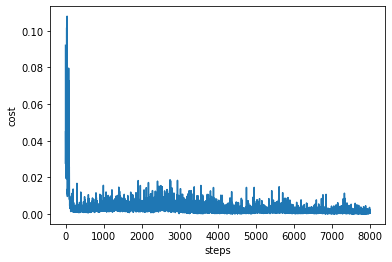

In [5]:
totle_steps = 0


observation = env.reset()
while True:
    env.render()
    action = RL_doubleq.choose_action(observation)  #0,1,2.。。10

    f_action = (action-(ACTION_SPACE-1)/2)/((ACTION_SPACE-1)/4)     #转换到[-2,2]的浮点数动作区间里
    print(f_action)
    observation_, reward, done, info = env.step(np.array([f_action])) #还有一个叫做info

    #修改一下默认env里面的奖励函数，怎么知道怎么改，pycharm里面搜索源文件
    reward /= 10 #normalize一下reward


    RL_doubleq.store_transition(observation, action, reward, observation_)

    if totle_steps>2000:
        RL_doubleq.learn()

    if totle_steps > 10000:
        break

    observation = observation_
    totle_steps += 1
        
RL_doubleq.plot_cost()
RL_doubleq.eval_net.save_weights('shuangbai_weights_doubleq.h5')

# 调用训练好的double_dqn


In [6]:
RL_new = DoubleDQN(n_actions=ACTION_SPACE,
                      n_features=env.observation_space.shape[0],
                      e_greedy=0.9)

In [7]:
RL_new.eval_net.load_weights('shuangbai_weights_doubleq.h5')

In [8]:
totle_steps = 0


observation = env.reset()
while True:
    env.render()
    action = RL_new.choose_action(observation)  #0,1,2.。。10

    f_action = (action-(ACTION_SPACE-1)/2)/((ACTION_SPACE-1)/4)     #转换到[-2,2]的浮点数动作区间里
    print(f_action)
    observation_, reward, done, info = env.step(np.array([f_action])) #还有一个叫做info

    if totle_steps > 20000:
        break

    observation = observation_
    totle_steps += 1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
1.6
1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
-1.6
0.8
-1.6
-1.6
-1.6
-1.6
-1.6
-1.2
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
-1.6
-1.6
-1.6
-1.6
0.4
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1

-1.6
-1.6
-1.6
-1.6
0.0
0.0
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
0.0
1.6
-1.6
-1.6
-1.6
0.4
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
0.0
-1.6
2.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
1.2
-1.6
-1.6
-1.6
-1.6
-1.6
-1.2
0.0
0.0
-1.6
-1.6
-1.6
-2.0
-1.6
-1.6
-1.6
-1.6
-1.6
2.0
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-0.8
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
2.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.2
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
2.0
0.0
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
2.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
1.6
-1.6
1.2
-1.6
-1.6
-2.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
0.0
-

0.0
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.2
-1.6
-1.6
0.0
0.0
0.0
0.0
-1.2
-1.6
1.2
-1.6
-1.6
-2.0
-0.8
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
2.0
0.0
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-2.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
1.6
0.0
0.0
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
0.0
0.0
0.0
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6
-1.6


KeyboardInterrupt: 